In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для генерации данных
def generate_circular_data(radius=5, steps=360, dt=0.1):
    true_states = []
    measurements = []
    x = np.array([radius, 0.0, 0.0, radius])  # x, y, vx, vy
    for _ in range(steps):
        x = f(x, dt)
        z = h(x) + np.random.normal(0, 0.1, size=2)
        true_states.append(x[:2])
        measurements.append(z)
    return np.array(true_states), np.array(measurements)

# Функции перехода и наблюдения
def f(x, dt):
    omega = 0.3  # угловая скорость
    r = np.sqrt(x[0]**2 + x[1]**2)
    theta = np.arctan2(x[1], x[0])
    new_theta = theta + omega * dt
    new_x = r * np.cos(new_theta)
    new_y = r * np.sin(new_theta)
    return np.array([new_x, new_y, -omega * new_y, omega * new_x])

def h(x):
    return np.array([x[0], x[1]])

In [2]:
class KalmanFilter:
    def __init__(self, F, H, Q, R, P, x0):
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
        self.P = P
        self.x = x0

    def predict(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.H.shape[1])
        self.P = np.dot((I - np.dot(K, self.H)), self.P)
        return self.x

class ExtendedKalmanFilter:
    def __init__(self, f, h, Q, R, P, x0):
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.P = P
        self.x = x0

    def predict(self, u=0):
        self.x = self.f(self.x, u)
        F = self.jacobian_f(self.x, u)
        self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
        return self.x

    def update(self, z):
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(len(self.x))
        self.P = np.dot((I - np.dot(K, H)), self.P)
        return self.x

    def jacobian_f(self, x, u):
        omega = 0.3
        dt = u
        theta = np.arctan2(x[1], x[0])
        return np.array([
            [1, 0, -dt * np.sin(theta), dt * np.cos(theta)],
            [0, 1, dt * np.cos(theta), dt * np.sin(theta)],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

    def jacobian_h(self, x):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

In [3]:
# Параметры для EKF
Q_ekf = np.eye(4) * 0.1
R_ekf = np.eye(2) * 0.5
P_ekf = np.eye(4) * 1.0
x0_ekf = np.array([5.0, 0.0, 0.0, 5.0])  # Радиус = 5

# Параметры для KF
F_kf_2d = np.array([
    [1, 0, 0.1, 0],
    [0, 1, 0, 0.1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
H_kf_2d = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
Q_kf_2d = np.eye(4) * 0.01
R_kf_2d = np.eye(2) * 0.5
P_kf_2d = np.eye(4) * 0.1
x0_kf_2d = np.array([5.0, 0.0, 0.0, 5.0]).reshape(-1, 1)  # Радиус = 5

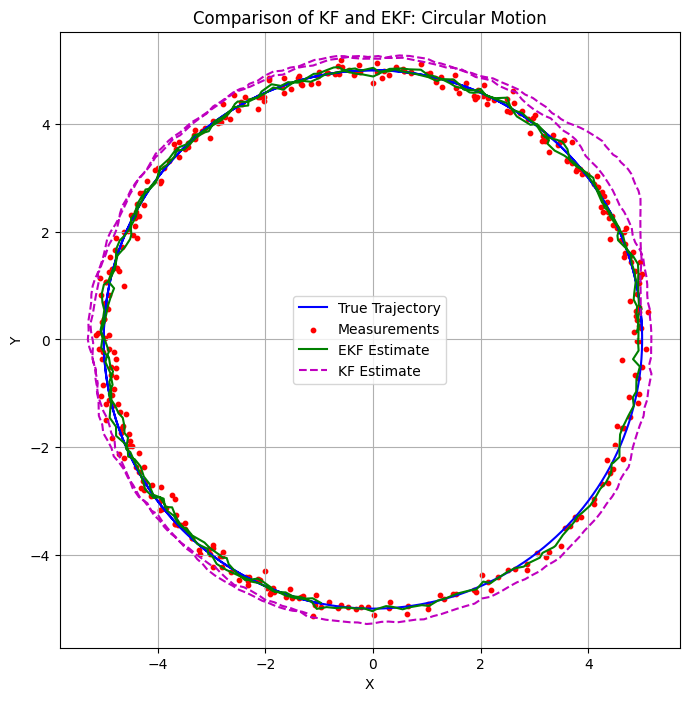

In [4]:
# Создание фильтров
ekf = ExtendedKalmanFilter(f, h, Q_ekf, R_ekf, P_ekf, x0_ekf)
kf = KalmanFilter(F_kf_2d, H_kf_2d, Q_kf_2d, R_kf_2d, P_kf_2d, x0_kf_2d)

# Генерация данных
true_states_c, measurements_c = generate_circular_data(radius=5, steps=360, dt=0.1)

# Списки для хранения оценок
ekf_estimates_c = []
kf_estimates_c = []

# Прогон через EKF
for z in measurements_c:
    ekf.predict(u=0.1)
    ekf.update(z)
    ekf_estimates_c.append(ekf.x[:2].copy())

# Прогон через KF
for z in measurements_c:
    kf.predict()
    kf.update(np.array([z]).reshape(-1, 1))
    kf_estimates_c.append(kf.x[:2].copy())

# Преобразование списков в массивы NumPy
ekf_estimates_c = np.array(ekf_estimates_c)
kf_estimates_c = np.array(kf_estimates_c)

# Визуализация
plt.figure(figsize=(8, 8))
plt.plot(true_states_c[:, 0], true_states_c[:, 1], label='True Trajectory', color='blue')
plt.scatter(measurements_c[:, 0], measurements_c[:, 1], c='r', s=10, label='Measurements')
plt.plot(ekf_estimates_c[:, 0], ekf_estimates_c[:, 1], 'g-', label='EKF Estimate')
plt.plot(kf_estimates_c[:, 0], kf_estimates_c[:, 1], 'm--', label='KF Estimate')  # Magenta dashed line
plt.title('Comparison of KF and EKF: Circular Motion')
plt.legend()
plt.axis('equal')
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()